# Importing resources

In [ ]:
# Replicate local resources
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/ai4eng.v1/main/content/init.py
import init; init.init(force_download=False); init.get_weblink()

In [ ]:
# Download the .zip file with the content of the Kaggle contest
import os
os.environ['KAGGLE_CONFIG_DIR'] = '.'
!chmod 600 ./kaggle.json
!kaggle competitions download -c udea-ai4eng-20242

 99% 20.0M/20.1M [00:00<00:00, 66.0MB/s]
100% 20.1M/20.1M [00:00<00:00, 55.7MB/s]


In [ ]:
# Unzip the file with the content of the Kaggle contest
!unzip udea*.zip > /dev/null

In [ ]:
# List the unzipped files
!wc *.csv

   296787    296787   4716673 submission_example.csv
   296787   4565553  50135751 test.csv
   692501  10666231 118025055 train.csv
  1286075  15528571 172877479 total


In [ ]:
# Import the needed libraries in this Colab
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [ ]:
# Read a load in dataframes the data of this project
data_train = pd.read_csv("train.csv")
data_test = pd.read_csv("test.csv")
data_submission_example = pd.read_csv("submission_example.csv")

In [ ]:
# Work on dataframe copies
data_train_copy = data_train.copy()
data_test_copy = data_test.copy()
data_submission_example_copy = data_submission_example.copy()

In [ ]:
# Data view of first rows
data_train_copy.head(5)

,ID,PERIODO,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_EDUCACIONMADRE,ESTU_PAGOMATRICULAPROPIO,RENDIMIENTO_GLOBAL
0,904256,20212,ENFERMERIA,BOGOTÁ,Entre 5.5 millones y menos de 7 millones,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica incompleta,Postgrado,No,medio-alto
1,645256,20212,DERECHO,ATLANTICO,Entre 2.5 millones y menos de 4 millones,0,Estrato 3,No,Técnica o tecnológica completa,Técnica o tecnológica incompleta,No,bajo
2,308367,20203,MERCADEO Y PUBLICIDAD,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Secundaria (Bachillerato) completa,No,bajo
3,470353,20195,ADMINISTRACION DE EMPRESAS,SANTANDER,Entre 4 millones y menos de 5.5 millones,0,Estrato 4,Si,No sabe,Secundaria (Bachillerato) completa,No,alto
4,989032,20212,PSICOLOGIA,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 3,Si,Primaria completa,Primaria completa,No,medio-bajo


# Data cleaning

In [ ]:
# In this method, I start to clean up columns one by one and fill NaN values in a custom way from parents information beacause I think the parental backgroud is beginig point to fill the dataset
def data_cleanup_1(dataset): #It return dataset with all its columns execept the ESTU_PRGM_ACADEMICO column
  # Set the ID column as the index column
  dataset = dataset.set_index("ID")

  # Delete PERIODO column
  #del dataset['PERIODO']

  # Delete ESTU_PRGM_ACADEMICO
  del dataset['ESTU_PRGM_ACADEMICO']

  # Delete ESTU_PRGM_DEPARTAMENTO
  #del dataset['ESTU_PRGM_DEPARTAMENTO']

  # Replace 'Ninguno', 'No Aplica', and NaN values with 'No sabe' in FAMI_EDUCACIONPADRE column
  dataset['FAMI_EDUCACIONPADRE'] = dataset['FAMI_EDUCACIONPADRE'].replace({
      'Ninguno': 'No sabe',
      'No Aplica': 'No sabe',
      np.nan: 'No sabe'
  })

  # Replace 'Ninguno', 'No Aplica', and NaN values with 'No sabe' in FAMI_EDUCACIONMADRE column
  dataset['FAMI_EDUCACIONMADRE'] = dataset['FAMI_EDUCACIONMADRE'].replace({
      'Ninguno': 'No sabe',
      'No Aplica': 'No sabe',
      np.nan: 'No sabe'
  })

  # Replace NaN values with 'Sin Estrato' in FAMI_ESTRATOVIVIENDA column
  dataset['FAMI_ESTRATOVIVIENDA'] = dataset['FAMI_ESTRATOVIVIENDA'].replace({
      np.nan: 'Sin Estrato'
  })

  # Replacement mappings based on education level
  group1 = {'Postgrado', 'Educación profesional completa', 'Educación profesional incompleta'}
  group2 = {'Técnica o tecnológica completa', 'Técnica o tecnológica incompleta', 'Secundaria (Bachillerato) completa', 'Secundaria (Bachillerato) incompleta'}
  group3 = {'Primaria completa', 'Primaria incompleta'}

  # List of all possible Estratos for random selection
  all_estratos = ['Estrato 3', 'Estrato 4', 'Estrato 5', 'Estrato 2', 'Estrato 1', 'Estrato 6']
  estrato_primaria = ['Estrato 1', 'Estrato 2']

  # Custom function to perform replacements of 'Sin Estrato' values in FAMI_ESTRATOVIVIENDA column based on parents education level
  def replace_sin_estrato(row):
      if row['FAMI_ESTRATOVIVIENDA'] != 'Sin Estrato':
          return row['FAMI_ESTRATOVIVIENDA']

      padre_edu = row['FAMI_EDUCACIONPADRE']
      madre_edu = row['FAMI_EDUCACIONMADRE']

      # Replace with 'Estrato 4' if any parent has a value in group1
      if padre_edu in group1 or madre_edu in group1:
          return 'Estrato 4'

      # Replace with 'Estrato 3' if any parent has a value in group2
      if padre_edu in group2 or madre_edu in group2:
          return 'Estrato 3'

      # Replace with 'Estrato 1' or 'Estrato 2' randomly if any parent has a value in group3
      if padre_edu in group3 or madre_edu in group3:
          return np.random.choice(estrato_primaria)

      # If both parents have 'No sabe', choose randomly from all estratos
      if padre_edu == 'No sabe' and madre_edu == 'No sabe':
          return np.random.choice(all_estratos)

      # Return the original value if none of the above rules match
      return row['FAMI_ESTRATOVIVIENDA']

  # Apply the custom function replace_sin_estrato to each row
  dataset['FAMI_ESTRATOVIVIENDA'] = dataset.apply(replace_sin_estrato, axis=1)

  # Replacement mappings based on average enrollment price
  # Define the value mapping for `ESTU_VALORMATRICULAUNIVERSIDAD`
  enrollment_price_mapping = {
      'Más de 7 millones': 7.75,
      'Entre 5.5 millones y menos de 7 millones': 6.25,
      'Entre 4 millones y menos de 5.5 millones': 4.75,
      'Entre 2.5 millones y menos de 4 millones': 3.25,
      'Entre 1 millón y menos de 2.5 millones': 1.75,
      'Entre 500 mil y menos de 1 millón': 0.75,
      'Menos de 500 mil': 0.25,
      'No pagó matrícula': 0.00
  }

  # Replace the values in the `ESTU_VALORMATRICULAUNIVERSIDAD` column using the defined enrollment_price_mapping
  dataset['ESTU_VALORMATRICULAUNIVERSIDAD'] = dataset['ESTU_VALORMATRICULAUNIVERSIDAD'].map(enrollment_price_mapping)

  # Create a custom function to handle `NaN` values in ESTU_VALORMATRICULAUNIVERSIDAD based on `FAMI_ESTRATOVIVIENDA`
  def replace_nan_estu_valormatriculauniversidad(row):
      if pd.notnull(row['ESTU_VALORMATRICULAUNIVERSIDAD']):
          return row['ESTU_VALORMATRICULAUNIVERSIDAD']

      estrato = row['FAMI_ESTRATOVIVIENDA']

      # Replace NaN based on `FAMI_ESTRATOVIVIENDA` column
      if estrato == 'Estrato 6':
          return 7.75
      elif estrato == 'Estrato 5':
          return 6.25
      elif estrato == 'Estrato 4':
         return 4.75
      elif estrato == 'Estrato 3':
          return np.random.choice([3.25, 1.75])
      elif estrato == 'Estrato 2':
          return np.random.choice([0.00, 0.25, 0.75])
      elif estrato == 'Estrato 1':
          return 0.00
      else:
          return row['ESTU_VALORMATRICULAUNIVERSIDAD']

  # Apply the custom function replace_nan_estu_valormatriculauniversidad to handle NaN values in the ESTU_VALORMATRICULAUNIVERSIDAD column
  dataset['ESTU_VALORMATRICULAUNIVERSIDAD'] = dataset.apply(replace_nan_estu_valormatriculauniversidad, axis=1)

  # Replacement mappings based on average working hours
  # Define the value mapping for working hours
  working_hours_mapping = {
      'Más de 30 horas': 35,
      'Entre 21 y 30 horas': 25,
      'Entre 11 y 20 horas': 15,
      'Menos de 10 horas': 5,
      '0': 0
  }

  # Replace the values in the `ESTU_HORASSEMANATRABAJA` column for int values using the defined working_hours_mapping
  dataset['ESTU_HORASSEMANATRABAJA'] = dataset['ESTU_HORASSEMANATRABAJA'].map(working_hours_mapping)

  # Create a custom function to handle NaN values randomly in ESTU_HORASSEMANATRABAJA column
  def replace_nan_with_random_estu_horassemanatrabaja(row):
      if pd.notnull(row['ESTU_HORASSEMANATRABAJA']):
          return row['ESTU_HORASSEMANATRABAJA']
      else:
          return np.random.choice([35, 25, 15, 5, 0])

  # Apply the custom function to replace NaN values in the DataFrame
  dataset['ESTU_HORASSEMANATRABAJA'] = dataset.apply(replace_nan_with_random_estu_horassemanatrabaja, axis=1)

  # Replacement of FAMI_TIENEINTERNET column values based on Estrato mapping
  # Replace 'Si' and 'No' with True and False in FAMI_TIENEINTERNET column
  dataset['FAMI_TIENEINTERNET'] = dataset['FAMI_TIENEINTERNET'].map({'Si': 1, 'No': 0})

  # Create a custom function to handle NaN values in FAMI_TIENEINTERNET column
  def replace_nan_with_boolean(row):
      if pd.notnull(row['FAMI_TIENEINTERNET']):
          return row['FAMI_TIENEINTERNET']
      else:
          estrato = row['FAMI_ESTRATOVIVIENDA']
          if estrato in {'Estrato 6', 'Estrato 4', 'Estrato 5'}:
              return 1
          elif estrato in {'Estrato 1', 'Estrato 2', 'Estrato 3'}:
              return 0
          else:
              return row['FAMI_TIENEINTERNET']  # Return the same if estrato does not match

  # Apply the custom function to replace NaN values in the DataFrame
  dataset['FAMI_TIENEINTERNET'] = dataset.apply(replace_nan_with_boolean, axis=1)
  dataset['FAMI_TIENEINTERNET'] = dataset['FAMI_TIENEINTERNET'].astype(int)

  # Replace 'Si' and 'No' with Boolean True and False in ESTU_PAGOMATRICULAPROPIO column
  dataset['ESTU_PAGOMATRICULAPROPIO'] = dataset['ESTU_PAGOMATRICULAPROPIO'].map({'Si': 1, 'No': 0})

  # Replace NaN values in ESTU_PAGOMATRICULAPROPIO column with a random choice between True and False
  dataset['ESTU_PAGOMATRICULAPROPIO'] = dataset['ESTU_PAGOMATRICULAPROPIO'].apply(lambda x: np.random.choice([1, 0]) if pd.isna(x) else x)
  dataset['ESTU_PAGOMATRICULAPROPIO'] = dataset['ESTU_PAGOMATRICULAPROPIO'].astype(int)

  # Replacement mappings Estrato categories for int values in FAMI_ESTRATOVIVIENDA column
  dataset['FAMI_ESTRATOVIVIENDA'] = dataset['FAMI_ESTRATOVIVIENDA'].map({
      'Estrato 1': 1,
      'Estrato 2': 2,
      'Estrato 3': 3,
      'Estrato 4': 4,
      'Estrato 5': 5,
      'Estrato 6': 6
  })

  # Replacement mapping FAMI_EDUCACIONMADRE column values for int values
  dataset['FAMI_EDUCACIONMADRE'] = dataset['FAMI_EDUCACIONMADRE'].map({
      'No sabe': 0,
      'Primaria incompleta': 1,
      'Primaria completa': 2,
      'Secundaria (Bachillerato) incompleta': 3,
      'Secundaria (Bachillerato) completa': 4,
      'Técnica o tecnológica incompleta': 5,
      'Técnica o tecnológica completa': 6,
      'Educación profesional incompleta': 7,
      'Educación profesional completa': 8,
      'Postgrado': 9
  })

  # Replacement mapping FAMI_EDUCACIONPADRE column values for int values
  dataset['FAMI_EDUCACIONPADRE'] = dataset['FAMI_EDUCACIONPADRE'].map({
      'No sabe': 0,
      'Primaria incompleta': 1,
      'Primaria completa': 2,
      'Secundaria (Bachillerato) incompleta': 3,
      'Secundaria (Bachillerato) completa': 4,
      'Técnica o tecnológica incompleta': 5,
      'Técnica o tecnológica completa': 6,
      'Educación profesional incompleta': 7,
      'Educación profesional completa': 8,
      'Postgrado': 9
  })

  # Perform one-hot encoding on the ESTU_PRGM_DEPARTAMENTO column
  dataset = to_one_hot(dataset, 'ESTU_PRGM_DEPARTAMENTO')

  # Perform one-hot encoding on the PERIODO column
  dataset = to_one_hot(dataset, 'PERIODO')

  return dataset

# Replacement mapping RENDIMIENTO_GLOBAL column values for int values
def replace_rendimiento_global_with_int(dataset):
  dataset['RENDIMIENTO_GLOBAL'] = dataset['RENDIMIENTO_GLOBAL'].map({
      'bajo': 1,
      'medio-bajo': 2,
      'medio-alto': 3,
      'alto': 4
  })
  return dataset

# Perform one-hot encoding on the column_name column and replace the column_name
def to_one_hot(dataset, column_name):
  # Perform one-hot encoding on the column_name column
  df_onehot = pd.get_dummies(dataset[column_name], prefix=column_name)

  # Find the index position of column_name column
  col_index = dataset.columns.get_loc(column_name)

  # Drop the original column_name column
  dataset = dataset.drop(column_name, axis=1)

  # Insert the one-hot encoded columns at the original position
  for i, col_name in enumerate(df_onehot.columns):
      dataset.insert(col_index + i, col_name, df_onehot[col_name].astype(int))

  return dataset

In [ ]:
# In this method, I start to clean up columns one by one and fill NaN values in a custom way from parents information beacause I think the parental backgroud is beginig point to fill the dataset
def data_cleanup_2(dataset): #It return dataset with all its columns execept the ESTU_PRGM_ACADEMICO and PERIODO column
  # Set the ID column as the index column
  dataset = dataset.set_index("ID")

  # Delete PERIODO column
  del dataset['PERIODO']

  # Delete ESTU_PRGM_ACADEMICO
  del dataset['ESTU_PRGM_ACADEMICO']

  # Delete ESTU_PRGM_DEPARTAMENTO
  #del dataset['ESTU_PRGM_DEPARTAMENTO']

  # Replace 'Ninguno', 'No Aplica', and NaN values with 'No sabe' in FAMI_EDUCACIONPADRE column
  dataset['FAMI_EDUCACIONPADRE'] = dataset['FAMI_EDUCACIONPADRE'].replace({
      'Ninguno': 'No sabe',
      'No Aplica': 'No sabe',
      np.nan: 'No sabe'
  })

  # Replace 'Ninguno', 'No Aplica', and NaN values with 'No sabe' in FAMI_EDUCACIONMADRE column
  dataset['FAMI_EDUCACIONMADRE'] = dataset['FAMI_EDUCACIONMADRE'].replace({
      'Ninguno': 'No sabe',
      'No Aplica': 'No sabe',
      np.nan: 'No sabe'
  })

  # Replace NaN values with 'Sin Estrato' in FAMI_ESTRATOVIVIENDA column
  dataset['FAMI_ESTRATOVIVIENDA'] = dataset['FAMI_ESTRATOVIVIENDA'].replace({
      np.nan: 'Sin Estrato'
  })

  # Replacement mappings based on education level
  group1 = {'Postgrado', 'Educación profesional completa', 'Educación profesional incompleta'}
  group2 = {'Técnica o tecnológica completa', 'Técnica o tecnológica incompleta', 'Secundaria (Bachillerato) completa', 'Secundaria (Bachillerato) incompleta'}
  group3 = {'Primaria completa', 'Primaria incompleta'}

  # List of all possible Estratos for random selection
  all_estratos = ['Estrato 3', 'Estrato 4', 'Estrato 5', 'Estrato 2', 'Estrato 1', 'Estrato 6']
  estrato_primaria = ['Estrato 1', 'Estrato 2']

  # Custom function to perform replacements of 'Sin Estrato' values in FAMI_ESTRATOVIVIENDA column based on parents education level
  def replace_sin_estrato(row):
      if row['FAMI_ESTRATOVIVIENDA'] != 'Sin Estrato':
          return row['FAMI_ESTRATOVIVIENDA']

      padre_edu = row['FAMI_EDUCACIONPADRE']
      madre_edu = row['FAMI_EDUCACIONMADRE']

      # Replace with 'Estrato 4' if any parent has a value in group1
      if padre_edu in group1 or madre_edu in group1:
          return 'Estrato 4'

      # Replace with 'Estrato 3' if any parent has a value in group2
      if padre_edu in group2 or madre_edu in group2:
          return 'Estrato 3'

      # Replace with 'Estrato 1' or 'Estrato 2' randomly if any parent has a value in group3
      if padre_edu in group3 or madre_edu in group3:
          return np.random.choice(estrato_primaria)

      # If both parents have 'No sabe', choose randomly from all estratos
      if padre_edu == 'No sabe' and madre_edu == 'No sabe':
          return np.random.choice(all_estratos)

      # Return the original value if none of the above rules match
      return row['FAMI_ESTRATOVIVIENDA']

  # Apply the custom function replace_sin_estrato to each row
  dataset['FAMI_ESTRATOVIVIENDA'] = dataset.apply(replace_sin_estrato, axis=1)

  # Replacement mappings based on average enrollment price
  # Define the value mapping for `ESTU_VALORMATRICULAUNIVERSIDAD`
  enrollment_price_mapping = {
      'Más de 7 millones': 7.75,
      'Entre 5.5 millones y menos de 7 millones': 6.25,
      'Entre 4 millones y menos de 5.5 millones': 4.75,
      'Entre 2.5 millones y menos de 4 millones': 3.25,
      'Entre 1 millón y menos de 2.5 millones': 1.75,
      'Entre 500 mil y menos de 1 millón': 0.75,
      'Menos de 500 mil': 0.25,
      'No pagó matrícula': 0.00
  }

  # Replace the values in the `ESTU_VALORMATRICULAUNIVERSIDAD` column using the defined enrollment_price_mapping
  dataset['ESTU_VALORMATRICULAUNIVERSIDAD'] = dataset['ESTU_VALORMATRICULAUNIVERSIDAD'].map(enrollment_price_mapping)

  # Create a custom function to handle `NaN` values in ESTU_VALORMATRICULAUNIVERSIDAD based on `FAMI_ESTRATOVIVIENDA`
  def replace_nan_estu_valormatriculauniversidad(row):
      if pd.notnull(row['ESTU_VALORMATRICULAUNIVERSIDAD']):
          return row['ESTU_VALORMATRICULAUNIVERSIDAD']

      estrato = row['FAMI_ESTRATOVIVIENDA']

      # Replace NaN based on `FAMI_ESTRATOVIVIENDA` column
      if estrato == 'Estrato 6':
          return 7.75
      elif estrato == 'Estrato 5':
          return 6.25
      elif estrato == 'Estrato 4':
         return 4.75
      elif estrato == 'Estrato 3':
          return np.random.choice([3.25, 1.75])
      elif estrato == 'Estrato 2':
          return np.random.choice([0.00, 0.25, 0.75])
      elif estrato == 'Estrato 1':
          return 0.00
      else:
          return row['ESTU_VALORMATRICULAUNIVERSIDAD']

  # Apply the custom function replace_nan_estu_valormatriculauniversidad to handle NaN values in the ESTU_VALORMATRICULAUNIVERSIDAD column
  dataset['ESTU_VALORMATRICULAUNIVERSIDAD'] = dataset.apply(replace_nan_estu_valormatriculauniversidad, axis=1)

  # Replacement mappings based on average working hours
  # Define the value mapping for working hours
  working_hours_mapping = {
      'Más de 30 horas': 35,
      'Entre 21 y 30 horas': 25,
      'Entre 11 y 20 horas': 15,
      'Menos de 10 horas': 5,
      '0': 0
  }

  # Replace the values in the `ESTU_HORASSEMANATRABAJA` column for int values using the defined working_hours_mapping
  dataset['ESTU_HORASSEMANATRABAJA'] = dataset['ESTU_HORASSEMANATRABAJA'].map(working_hours_mapping)

  # Create a custom function to handle NaN values randomly in ESTU_HORASSEMANATRABAJA column
  def replace_nan_with_random_estu_horassemanatrabaja(row):
      if pd.notnull(row['ESTU_HORASSEMANATRABAJA']):
          return row['ESTU_HORASSEMANATRABAJA']
      else:
          return np.random.choice([35, 25, 15, 5, 0])

  # Apply the custom function to replace NaN values in the DataFrame
  dataset['ESTU_HORASSEMANATRABAJA'] = dataset.apply(replace_nan_with_random_estu_horassemanatrabaja, axis=1)

  # Replacement of FAMI_TIENEINTERNET column values based on Estrato mapping
  # Replace 'Si' and 'No' with True and False in FAMI_TIENEINTERNET column
  dataset['FAMI_TIENEINTERNET'] = dataset['FAMI_TIENEINTERNET'].map({'Si': 1, 'No': 0})

  # Create a custom function to handle NaN values in FAMI_TIENEINTERNET column
  def replace_nan_with_boolean(row):
      if pd.notnull(row['FAMI_TIENEINTERNET']):
          return row['FAMI_TIENEINTERNET']
      else:
          estrato = row['FAMI_ESTRATOVIVIENDA']
          if estrato in {'Estrato 6', 'Estrato 4', 'Estrato 5'}:
              return 1
          elif estrato in {'Estrato 1', 'Estrato 2', 'Estrato 3'}:
              return 0
          else:
              return row['FAMI_TIENEINTERNET']  # Return the same if estrato does not match

  # Apply the custom function to replace NaN values in the DataFrame
  dataset['FAMI_TIENEINTERNET'] = dataset.apply(replace_nan_with_boolean, axis=1)
  dataset['FAMI_TIENEINTERNET'] = dataset['FAMI_TIENEINTERNET'].astype(int)

  # Replace 'Si' and 'No' with Boolean True and False in ESTU_PAGOMATRICULAPROPIO column
  dataset['ESTU_PAGOMATRICULAPROPIO'] = dataset['ESTU_PAGOMATRICULAPROPIO'].map({'Si': 1, 'No': 0})

  # Replace NaN values in ESTU_PAGOMATRICULAPROPIO column with a random choice between True and False
  dataset['ESTU_PAGOMATRICULAPROPIO'] = dataset['ESTU_PAGOMATRICULAPROPIO'].apply(lambda x: np.random.choice([1, 0]) if pd.isna(x) else x)
  dataset['ESTU_PAGOMATRICULAPROPIO'] = dataset['ESTU_PAGOMATRICULAPROPIO'].astype(int)

  # Replacement mappings Estrato categories for int values in FAMI_ESTRATOVIVIENDA column
  dataset['FAMI_ESTRATOVIVIENDA'] = dataset['FAMI_ESTRATOVIVIENDA'].map({
      'Estrato 1': 1,
      'Estrato 2': 2,
      'Estrato 3': 3,
      'Estrato 4': 4,
      'Estrato 5': 5,
      'Estrato 6': 6
  })

  # Replacement mapping FAMI_EDUCACIONMADRE column values for int values
  dataset['FAMI_EDUCACIONMADRE'] = dataset['FAMI_EDUCACIONMADRE'].map({
      'No sabe': 0,
      'Primaria incompleta': 1,
      'Primaria completa': 2,
      'Secundaria (Bachillerato) incompleta': 3,
      'Secundaria (Bachillerato) completa': 4,
      'Técnica o tecnológica incompleta': 5,
      'Técnica o tecnológica completa': 6,
      'Educación profesional incompleta': 7,
      'Educación profesional completa': 8,
      'Postgrado': 9
  })

  # Replacement mapping FAMI_EDUCACIONPADRE column values for int values
  dataset['FAMI_EDUCACIONPADRE'] = dataset['FAMI_EDUCACIONPADRE'].map({
      'No sabe': 0,
      'Primaria incompleta': 1,
      'Primaria completa': 2,
      'Secundaria (Bachillerato) incompleta': 3,
      'Secundaria (Bachillerato) completa': 4,
      'Técnica o tecnológica incompleta': 5,
      'Técnica o tecnológica completa': 6,
      'Educación profesional incompleta': 7,
      'Educación profesional completa': 8,
      'Postgrado': 9
  })

  # Perform one-hot encoding on the ESTU_PRGM_DEPARTAMENTO column
  dataset = to_one_hot(dataset, 'ESTU_PRGM_DEPARTAMENTO')

  # Perform one-hot encoding on the PERIODO column
  #dataset = to_one_hot(dataset, 'PERIODO')

  return dataset

In [ ]:
# In this method, I start to clean up columns one by one and fill NaN values in a custom way from parents information beacause I think the parental backgroud is beginig point to fill the dataset
def data_cleanup_3(dataset): #It return dataset with all its columns execept the ESTU_PRGM_ACADEMICO, PERIODO and ESTU_PRGM_DEPARTAMENTO column
  # Set the ID column as the index column
  dataset = dataset.set_index("ID")

  # Delete PERIODO column
  del dataset['PERIODO']

  # Delete ESTU_PRGM_ACADEMICO
  del dataset['ESTU_PRGM_ACADEMICO']

  # Delete ESTU_PRGM_DEPARTAMENTO
  del dataset['ESTU_PRGM_DEPARTAMENTO']

  # Replace 'Ninguno', 'No Aplica', and NaN values with 'No sabe' in FAMI_EDUCACIONPADRE column
  dataset['FAMI_EDUCACIONPADRE'] = dataset['FAMI_EDUCACIONPADRE'].replace({
      'Ninguno': 'No sabe',
      'No Aplica': 'No sabe',
      np.nan: 'No sabe'
  })

  # Replace 'Ninguno', 'No Aplica', and NaN values with 'No sabe' in FAMI_EDUCACIONMADRE column
  dataset['FAMI_EDUCACIONMADRE'] = dataset['FAMI_EDUCACIONMADRE'].replace({
      'Ninguno': 'No sabe',
      'No Aplica': 'No sabe',
      np.nan: 'No sabe'
  })

  # Replace NaN values with 'Sin Estrato' in FAMI_ESTRATOVIVIENDA column
  dataset['FAMI_ESTRATOVIVIENDA'] = dataset['FAMI_ESTRATOVIVIENDA'].replace({
      np.nan: 'Sin Estrato'
  })

  # Replacement mappings based on education level
  group1 = {'Postgrado', 'Educación profesional completa', 'Educación profesional incompleta'}
  group2 = {'Técnica o tecnológica completa', 'Técnica o tecnológica incompleta', 'Secundaria (Bachillerato) completa', 'Secundaria (Bachillerato) incompleta'}
  group3 = {'Primaria completa', 'Primaria incompleta'}

  # List of all possible Estratos for random selection
  all_estratos = ['Estrato 3', 'Estrato 4', 'Estrato 5', 'Estrato 2', 'Estrato 1', 'Estrato 6']
  estrato_primaria = ['Estrato 1', 'Estrato 2']

  # Custom function to perform replacements of 'Sin Estrato' values in FAMI_ESTRATOVIVIENDA column based on parents education level
  def replace_sin_estrato(row):
      if row['FAMI_ESTRATOVIVIENDA'] != 'Sin Estrato':
          return row['FAMI_ESTRATOVIVIENDA']

      padre_edu = row['FAMI_EDUCACIONPADRE']
      madre_edu = row['FAMI_EDUCACIONMADRE']

      # Replace with 'Estrato 4' if any parent has a value in group1
      if padre_edu in group1 or madre_edu in group1:
          return 'Estrato 4'

      # Replace with 'Estrato 3' if any parent has a value in group2
      if padre_edu in group2 or madre_edu in group2:
          return 'Estrato 3'

      # Replace with 'Estrato 1' or 'Estrato 2' randomly if any parent has a value in group3
      if padre_edu in group3 or madre_edu in group3:
          return np.random.choice(estrato_primaria)

      # If both parents have 'No sabe', choose randomly from all estratos
      if padre_edu == 'No sabe' and madre_edu == 'No sabe':
          return np.random.choice(all_estratos)

      # Return the original value if none of the above rules match
      return row['FAMI_ESTRATOVIVIENDA']

  # Apply the custom function replace_sin_estrato to each row
  dataset['FAMI_ESTRATOVIVIENDA'] = dataset.apply(replace_sin_estrato, axis=1)

  # Replacement mappings based on average enrollment price
  # Define the value mapping for `ESTU_VALORMATRICULAUNIVERSIDAD`
  enrollment_price_mapping = {
      'Más de 7 millones': 7.75,
      'Entre 5.5 millones y menos de 7 millones': 6.25,
      'Entre 4 millones y menos de 5.5 millones': 4.75,
      'Entre 2.5 millones y menos de 4 millones': 3.25,
      'Entre 1 millón y menos de 2.5 millones': 1.75,
      'Entre 500 mil y menos de 1 millón': 0.75,
      'Menos de 500 mil': 0.25,
      'No pagó matrícula': 0.00
  }

  # Replace the values in the `ESTU_VALORMATRICULAUNIVERSIDAD` column using the defined enrollment_price_mapping
  dataset['ESTU_VALORMATRICULAUNIVERSIDAD'] = dataset['ESTU_VALORMATRICULAUNIVERSIDAD'].map(enrollment_price_mapping)

  # Create a custom function to handle `NaN` values in ESTU_VALORMATRICULAUNIVERSIDAD based on `FAMI_ESTRATOVIVIENDA`
  def replace_nan_estu_valormatriculauniversidad(row):
      if pd.notnull(row['ESTU_VALORMATRICULAUNIVERSIDAD']):
          return row['ESTU_VALORMATRICULAUNIVERSIDAD']

      estrato = row['FAMI_ESTRATOVIVIENDA']

      # Replace NaN based on `FAMI_ESTRATOVIVIENDA` column
      if estrato == 'Estrato 6':
          return 7.75
      elif estrato == 'Estrato 5':
          return 6.25
      elif estrato == 'Estrato 4':
         return 4.75
      elif estrato == 'Estrato 3':
          return np.random.choice([3.25, 1.75])
      elif estrato == 'Estrato 2':
          return np.random.choice([0.00, 0.25, 0.75])
      elif estrato == 'Estrato 1':
          return 0.00
      else:
          return row['ESTU_VALORMATRICULAUNIVERSIDAD']

  # Apply the custom function replace_nan_estu_valormatriculauniversidad to handle NaN values in the ESTU_VALORMATRICULAUNIVERSIDAD column
  dataset['ESTU_VALORMATRICULAUNIVERSIDAD'] = dataset.apply(replace_nan_estu_valormatriculauniversidad, axis=1)

  # Replacement mappings based on average working hours
  # Define the value mapping for working hours
  working_hours_mapping = {
      'Más de 30 horas': 35,
      'Entre 21 y 30 horas': 25,
      'Entre 11 y 20 horas': 15,
      'Menos de 10 horas': 5,
      '0': 0
  }

  # Replace the values in the `ESTU_HORASSEMANATRABAJA` column for int values using the defined working_hours_mapping
  dataset['ESTU_HORASSEMANATRABAJA'] = dataset['ESTU_HORASSEMANATRABAJA'].map(working_hours_mapping)

  # Create a custom function to handle NaN values randomly in ESTU_HORASSEMANATRABAJA column
  def replace_nan_with_random_estu_horassemanatrabaja(row):
      if pd.notnull(row['ESTU_HORASSEMANATRABAJA']):
          return row['ESTU_HORASSEMANATRABAJA']
      else:
          return np.random.choice([35, 25, 15, 5, 0])

  # Apply the custom function to replace NaN values in the DataFrame
  dataset['ESTU_HORASSEMANATRABAJA'] = dataset.apply(replace_nan_with_random_estu_horassemanatrabaja, axis=1)

  # Replacement of FAMI_TIENEINTERNET column values based on Estrato mapping
  # Replace 'Si' and 'No' with True and False in FAMI_TIENEINTERNET column
  dataset['FAMI_TIENEINTERNET'] = dataset['FAMI_TIENEINTERNET'].map({'Si': 1, 'No': 0})

  # Create a custom function to handle NaN values in FAMI_TIENEINTERNET column
  def replace_nan_with_boolean(row):
      if pd.notnull(row['FAMI_TIENEINTERNET']):
          return row['FAMI_TIENEINTERNET']
      else:
          estrato = row['FAMI_ESTRATOVIVIENDA']
          if estrato in {'Estrato 6', 'Estrato 4', 'Estrato 5'}:
              return 1
          elif estrato in {'Estrato 1', 'Estrato 2', 'Estrato 3'}:
              return 0
          else:
              return row['FAMI_TIENEINTERNET']  # Return the same if estrato does not match

  # Apply the custom function to replace NaN values in the DataFrame
  dataset['FAMI_TIENEINTERNET'] = dataset.apply(replace_nan_with_boolean, axis=1)
  dataset['FAMI_TIENEINTERNET'] = dataset['FAMI_TIENEINTERNET'].astype(int)

  # Replace 'Si' and 'No' with Boolean True and False in ESTU_PAGOMATRICULAPROPIO column
  dataset['ESTU_PAGOMATRICULAPROPIO'] = dataset['ESTU_PAGOMATRICULAPROPIO'].map({'Si': 1, 'No': 0})

  # Replace NaN values in ESTU_PAGOMATRICULAPROPIO column with a random choice between True and False
  dataset['ESTU_PAGOMATRICULAPROPIO'] = dataset['ESTU_PAGOMATRICULAPROPIO'].apply(lambda x: np.random.choice([1, 0]) if pd.isna(x) else x)
  dataset['ESTU_PAGOMATRICULAPROPIO'] = dataset['ESTU_PAGOMATRICULAPROPIO'].astype(int)

  # Replacement mappings Estrato categories for int values in FAMI_ESTRATOVIVIENDA column
  dataset['FAMI_ESTRATOVIVIENDA'] = dataset['FAMI_ESTRATOVIVIENDA'].map({
      'Estrato 1': 1,
      'Estrato 2': 2,
      'Estrato 3': 3,
      'Estrato 4': 4,
      'Estrato 5': 5,
      'Estrato 6': 6
  })

  # Replacement mapping FAMI_EDUCACIONMADRE column values for int values
  dataset['FAMI_EDUCACIONMADRE'] = dataset['FAMI_EDUCACIONMADRE'].map({
      'No sabe': 0,
      'Primaria incompleta': 1,
      'Primaria completa': 2,
      'Secundaria (Bachillerato) incompleta': 3,
      'Secundaria (Bachillerato) completa': 4,
      'Técnica o tecnológica incompleta': 5,
      'Técnica o tecnológica completa': 6,
      'Educación profesional incompleta': 7,
      'Educación profesional completa': 8,
      'Postgrado': 9
  })

  # Replacement mapping FAMI_EDUCACIONPADRE column values for int values
  dataset['FAMI_EDUCACIONPADRE'] = dataset['FAMI_EDUCACIONPADRE'].map({
      'No sabe': 0,
      'Primaria incompleta': 1,
      'Primaria completa': 2,
      'Secundaria (Bachillerato) incompleta': 3,
      'Secundaria (Bachillerato) completa': 4,
      'Técnica o tecnológica incompleta': 5,
      'Técnica o tecnológica completa': 6,
      'Educación profesional incompleta': 7,
      'Educación profesional completa': 8,
      'Postgrado': 9
  })

  # Perform one-hot encoding on the ESTU_PRGM_DEPARTAMENTO column
  #dataset = to_one_hot(dataset, 'ESTU_PRGM_DEPARTAMENTO')

  # Perform one-hot encoding on the PERIODO column
  #dataset = to_one_hot(dataset, 'PERIODO')

  return dataset

In [ ]:
# In this method, I start to clean up columns one by one and fill NaN values in a custom way from parents information beacause I think the parental backgroud is beginig point to fill the dataset
def data_cleanup_4(dataset): #It return dataset with all its columns execept the ESTU_PRGM_ACADEMICO, PERIODO, ESTU_PRGM_DEPARTAMENTO and FAMI_TIENEINTERNET column
  # Set the ID column as the index column
  dataset = dataset.set_index("ID")

  # Delete PERIODO column
  del dataset['PERIODO']

  # Delete ESTU_PRGM_ACADEMICO
  del dataset['ESTU_PRGM_ACADEMICO']

  # Delete ESTU_PRGM_DEPARTAMENTO
  del dataset['ESTU_PRGM_DEPARTAMENTO']

  # Replace 'Ninguno', 'No Aplica', and NaN values with 'No sabe' in FAMI_EDUCACIONPADRE column
  dataset['FAMI_EDUCACIONPADRE'] = dataset['FAMI_EDUCACIONPADRE'].replace({
      'Ninguno': 'No sabe',
      'No Aplica': 'No sabe',
      np.nan: 'No sabe'
  })

  # Replace 'Ninguno', 'No Aplica', and NaN values with 'No sabe' in FAMI_EDUCACIONMADRE column
  dataset['FAMI_EDUCACIONMADRE'] = dataset['FAMI_EDUCACIONMADRE'].replace({
      'Ninguno': 'No sabe',
      'No Aplica': 'No sabe',
      np.nan: 'No sabe'
  })

  # Replace NaN values with 'Sin Estrato' in FAMI_ESTRATOVIVIENDA column
  dataset['FAMI_ESTRATOVIVIENDA'] = dataset['FAMI_ESTRATOVIVIENDA'].replace({
      np.nan: 'Sin Estrato'
  })

  # Replacement mappings based on education level
  group1 = {'Postgrado', 'Educación profesional completa', 'Educación profesional incompleta'}
  group2 = {'Técnica o tecnológica completa', 'Técnica o tecnológica incompleta', 'Secundaria (Bachillerato) completa', 'Secundaria (Bachillerato) incompleta'}
  group3 = {'Primaria completa', 'Primaria incompleta'}

  # List of all possible Estratos for random selection
  all_estratos = ['Estrato 3', 'Estrato 4', 'Estrato 5', 'Estrato 2', 'Estrato 1', 'Estrato 6']
  estrato_primaria = ['Estrato 1', 'Estrato 2']

  # Custom function to perform replacements of 'Sin Estrato' values in FAMI_ESTRATOVIVIENDA column based on parents education level
  def replace_sin_estrato(row):
      if row['FAMI_ESTRATOVIVIENDA'] != 'Sin Estrato':
          return row['FAMI_ESTRATOVIVIENDA']

      padre_edu = row['FAMI_EDUCACIONPADRE']
      madre_edu = row['FAMI_EDUCACIONMADRE']

      # Replace with 'Estrato 4' if any parent has a value in group1
      if padre_edu in group1 or madre_edu in group1:
          return 'Estrato 4'

      # Replace with 'Estrato 3' if any parent has a value in group2
      if padre_edu in group2 or madre_edu in group2:
          return 'Estrato 3'

      # Replace with 'Estrato 1' or 'Estrato 2' randomly if any parent has a value in group3
      if padre_edu in group3 or madre_edu in group3:
          return np.random.choice(estrato_primaria)

      # If both parents have 'No sabe', choose randomly from all estratos
      if padre_edu == 'No sabe' and madre_edu == 'No sabe':
          return np.random.choice(all_estratos)

      # Return the original value if none of the above rules match
      return row['FAMI_ESTRATOVIVIENDA']

  # Apply the custom function replace_sin_estrato to each row
  dataset['FAMI_ESTRATOVIVIENDA'] = dataset.apply(replace_sin_estrato, axis=1)

  # Replacement mappings based on average enrollment price
  # Define the value mapping for `ESTU_VALORMATRICULAUNIVERSIDAD`
  enrollment_price_mapping = {
      'Más de 7 millones': 7.75,
      'Entre 5.5 millones y menos de 7 millones': 6.25,
      'Entre 4 millones y menos de 5.5 millones': 4.75,
      'Entre 2.5 millones y menos de 4 millones': 3.25,
      'Entre 1 millón y menos de 2.5 millones': 1.75,
      'Entre 500 mil y menos de 1 millón': 0.75,
      'Menos de 500 mil': 0.25,
      'No pagó matrícula': 0.00
  }

  # Replace the values in the `ESTU_VALORMATRICULAUNIVERSIDAD` column using the defined enrollment_price_mapping
  dataset['ESTU_VALORMATRICULAUNIVERSIDAD'] = dataset['ESTU_VALORMATRICULAUNIVERSIDAD'].map(enrollment_price_mapping)

  # Create a custom function to handle `NaN` values in ESTU_VALORMATRICULAUNIVERSIDAD based on `FAMI_ESTRATOVIVIENDA`
  def replace_nan_estu_valormatriculauniversidad(row):
      if pd.notnull(row['ESTU_VALORMATRICULAUNIVERSIDAD']):
          return row['ESTU_VALORMATRICULAUNIVERSIDAD']

      estrato = row['FAMI_ESTRATOVIVIENDA']

      # Replace NaN based on `FAMI_ESTRATOVIVIENDA` column
      if estrato == 'Estrato 6':
          return 7.75
      elif estrato == 'Estrato 5':
          return 6.25
      elif estrato == 'Estrato 4':
         return 4.75
      elif estrato == 'Estrato 3':
          return np.random.choice([3.25, 1.75])
      elif estrato == 'Estrato 2':
          return np.random.choice([0.00, 0.25, 0.75])
      elif estrato == 'Estrato 1':
          return 0.00
      else:
          return row['ESTU_VALORMATRICULAUNIVERSIDAD']

  # Apply the custom function replace_nan_estu_valormatriculauniversidad to handle NaN values in the ESTU_VALORMATRICULAUNIVERSIDAD column
  dataset['ESTU_VALORMATRICULAUNIVERSIDAD'] = dataset.apply(replace_nan_estu_valormatriculauniversidad, axis=1)

  # Replacement mappings based on average working hours
  # Define the value mapping for working hours
  working_hours_mapping = {
      'Más de 30 horas': 35,
      'Entre 21 y 30 horas': 25,
      'Entre 11 y 20 horas': 15,
      'Menos de 10 horas': 5,
      '0': 0
  }

  # Replace the values in the `ESTU_HORASSEMANATRABAJA` column for int values using the defined working_hours_mapping
  dataset['ESTU_HORASSEMANATRABAJA'] = dataset['ESTU_HORASSEMANATRABAJA'].map(working_hours_mapping)

  # Create a custom function to handle NaN values randomly in ESTU_HORASSEMANATRABAJA column
  def replace_nan_with_random_estu_horassemanatrabaja(row):
      if pd.notnull(row['ESTU_HORASSEMANATRABAJA']):
          return row['ESTU_HORASSEMANATRABAJA']
      else:
          return np.random.choice([35, 25, 15, 5, 0])

  # Apply the custom function to replace NaN values in the DataFrame
  dataset['ESTU_HORASSEMANATRABAJA'] = dataset.apply(replace_nan_with_random_estu_horassemanatrabaja, axis=1)

  # Replacement of FAMI_TIENEINTERNET column values based on Estrato mapping
  # Replace 'Si' and 'No' with True and False in FAMI_TIENEINTERNET column
  dataset['FAMI_TIENEINTERNET'] = dataset['FAMI_TIENEINTERNET'].map({'Si': 1, 'No': 0})

  # Create a custom function to handle NaN values in FAMI_TIENEINTERNET column
  def replace_nan_with_boolean(row):
      if pd.notnull(row['FAMI_TIENEINTERNET']):
          return row['FAMI_TIENEINTERNET']
      else:
          estrato = row['FAMI_ESTRATOVIVIENDA']
          if estrato in {'Estrato 6', 'Estrato 4', 'Estrato 5'}:
              return 1
          elif estrato in {'Estrato 1', 'Estrato 2', 'Estrato 3'}:
              return 0
          else:
              return row['FAMI_TIENEINTERNET']  # Return the same if estrato does not match

  # Apply the custom function to replace NaN values in the DataFrame
  dataset['FAMI_TIENEINTERNET'] = dataset.apply(replace_nan_with_boolean, axis=1)
  dataset['FAMI_TIENEINTERNET'] = dataset['FAMI_TIENEINTERNET'].astype(int)

  # Replace 'Si' and 'No' with Boolean True and False in ESTU_PAGOMATRICULAPROPIO column
  dataset['ESTU_PAGOMATRICULAPROPIO'] = dataset['ESTU_PAGOMATRICULAPROPIO'].map({'Si': 1, 'No': 0})

  # Replace NaN values in ESTU_PAGOMATRICULAPROPIO column with a random choice between True and False
  dataset['ESTU_PAGOMATRICULAPROPIO'] = dataset['ESTU_PAGOMATRICULAPROPIO'].apply(lambda x: np.random.choice([1, 0]) if pd.isna(x) else x)
  dataset['ESTU_PAGOMATRICULAPROPIO'] = dataset['ESTU_PAGOMATRICULAPROPIO'].astype(int)

  # Replacement mappings Estrato categories for int values in FAMI_ESTRATOVIVIENDA column
  dataset['FAMI_ESTRATOVIVIENDA'] = dataset['FAMI_ESTRATOVIVIENDA'].map({
      'Estrato 1': 1,
      'Estrato 2': 2,
      'Estrato 3': 3,
      'Estrato 4': 4,
      'Estrato 5': 5,
      'Estrato 6': 6
  })

  # Replacement mapping FAMI_EDUCACIONMADRE column values for int values
  dataset['FAMI_EDUCACIONMADRE'] = dataset['FAMI_EDUCACIONMADRE'].map({
      'No sabe': 0,
      'Primaria incompleta': 1,
      'Primaria completa': 2,
      'Secundaria (Bachillerato) incompleta': 3,
      'Secundaria (Bachillerato) completa': 4,
      'Técnica o tecnológica incompleta': 5,
      'Técnica o tecnológica completa': 6,
      'Educación profesional incompleta': 7,
      'Educación profesional completa': 8,
      'Postgrado': 9
  })

  # Replacement mapping FAMI_EDUCACIONPADRE column values for int values
  dataset['FAMI_EDUCACIONPADRE'] = dataset['FAMI_EDUCACIONPADRE'].map({
      'No sabe': 0,
      'Primaria incompleta': 1,
      'Primaria completa': 2,
      'Secundaria (Bachillerato) incompleta': 3,
      'Secundaria (Bachillerato) completa': 4,
      'Técnica o tecnológica incompleta': 5,
      'Técnica o tecnológica completa': 6,
      'Educación profesional incompleta': 7,
      'Educación profesional completa': 8,
      'Postgrado': 9
  })

  # Perform one-hot encoding on the ESTU_PRGM_DEPARTAMENTO column
  #dataset = to_one_hot(dataset, 'ESTU_PRGM_DEPARTAMENTO')

  # Perform one-hot encoding on the PERIODO column
  #dataset = to_one_hot(dataset, 'PERIODO')

  # Drop the original column_name column
  dataset = dataset.drop("FAMI_TIENEINTERNET", axis=1)

  return dataset

In [ ]:
# Lets take a few diferent data frame with diferent cleaning

# this data have all its columns execept the ESTU_PRGM_ACADEMICO column
data_train_1 = data_cleanup_1(data_train_copy)
data_train_1 = replace_rendimiento_global_with_int(data_train_1)
data_train_1.head(5)

,PERIODO_20183,PERIODO_20184,PERIODO_20194,PERIODO_20195,PERIODO_20196,PERIODO_20202,PERIODO_20203,PERIODO_20212,PERIODO_20213,ESTU_PRGM_DEPARTAMENTO_AMAZONAS,...,ESTU_PRGM_DEPARTAMENTO_VALLE,ESTU_PRGM_DEPARTAMENTO_VAUPES,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_EDUCACIONMADRE,ESTU_PAGOMATRICULAPROPIO,RENDIMIENTO_GLOBAL
ID,,,,,,,,,,,,,,,,,,,,,
904256,0,0,0,0,0,0,0,1,0,0,...,0,0,6.25,5.0,3,1,5,9,0,3
645256,0,0,0,0,0,0,0,1,0,0,...,0,0,3.25,0.0,3,0,6,5,0,1
308367,0,0,0,0,0,0,1,0,0,0,...,0,0,3.25,35.0,3,1,4,4,0,1
470353,0,0,0,1,0,0,0,0,0,0,...,0,0,4.75,0.0,4,1,0,4,0,4
989032,0,0,0,0,0,0,0,1,0,0,...,0,0,3.25,25.0,3,1,2,2,0,2


In [ ]:
# this data have all its columns execept the ESTU_PRGM_ACADEMICO and PERIODO column
data_train_2 = data_cleanup_2(data_train_copy)
data_train_2 = replace_rendimiento_global_with_int(data_train_2)
data_train_2.head(5)

,ESTU_PRGM_DEPARTAMENTO_AMAZONAS,ESTU_PRGM_DEPARTAMENTO_ANTIOQUIA,ESTU_PRGM_DEPARTAMENTO_ARAUCA,ESTU_PRGM_DEPARTAMENTO_ATLANTICO,ESTU_PRGM_DEPARTAMENTO_BOGOTÁ,ESTU_PRGM_DEPARTAMENTO_BOLIVAR,ESTU_PRGM_DEPARTAMENTO_BOYACA,ESTU_PRGM_DEPARTAMENTO_CALDAS,ESTU_PRGM_DEPARTAMENTO_CAQUETA,ESTU_PRGM_DEPARTAMENTO_CASANARE,...,ESTU_PRGM_DEPARTAMENTO_VALLE,ESTU_PRGM_DEPARTAMENTO_VAUPES,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_EDUCACIONMADRE,ESTU_PAGOMATRICULAPROPIO,RENDIMIENTO_GLOBAL
ID,,,,,,,,,,,,,,,,,,,,,
904256,0,0,0,0,1,0,0,0,0,0,...,0,0,6.25,5.0,3,1,5,9,0,3
645256,0,0,0,1,0,0,0,0,0,0,...,0,0,3.25,0.0,3,0,6,5,0,1
308367,0,0,0,0,1,0,0,0,0,0,...,0,0,3.25,35.0,3,1,4,4,0,1
470353,0,0,0,0,0,0,0,0,0,0,...,0,0,4.75,0.0,4,1,0,4,0,4
989032,0,1,0,0,0,0,0,0,0,0,...,0,0,3.25,25.0,3,1,2,2,0,2


In [ ]:
# this data have all its columns execept the ESTU_PRGM_ACADEMICO, PERIODO and ESTU_PRGM_DEPARTAMENTO column
data_train_3 = data_cleanup_3(data_train_copy)
data_train_3 = replace_rendimiento_global_with_int(data_train_3)
data_train_3.head(5)

,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_EDUCACIONMADRE,ESTU_PAGOMATRICULAPROPIO,RENDIMIENTO_GLOBAL
ID,,,,,,,,
904256,6.25,5.0,3,1,5,9,0,3
645256,3.25,0.0,3,0,6,5,0,1
308367,3.25,35.0,3,1,4,4,0,1
470353,4.75,0.0,4,1,0,4,0,4
989032,3.25,25.0,3,1,2,2,0,2


In [ ]:
# this data have all its columns execept the ESTU_PRGM_ACADEMICO, PERIODO, ESTU_PRGM_DEPARTAMENTO and FAMI_TIENEINTERNET column
data_train_4 = data_cleanup_4(data_train_copy)
data_train_4 = replace_rendimiento_global_with_int(data_train_4)
data_train_4.head(5)

,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_EDUCACIONPADRE,FAMI_EDUCACIONMADRE,ESTU_PAGOMATRICULAPROPIO,RENDIMIENTO_GLOBAL
ID,,,,,,,
904256,6.25,5.0,3,5,9,0,3
645256,3.25,0.0,3,6,5,0,1
308367,3.25,35.0,3,4,4,0,1
470353,4.75,0.0,4,0,4,0,4
989032,3.25,25.0,3,2,2,0,2


In [ ]:
# Check that now no column has NaN values
for col in data_train_1.columns:
    print(col, data_train_1[col].isnull().any())

PERIODO_20183 False
PERIODO_20184 False
PERIODO_20194 False
PERIODO_20195 False
PERIODO_20196 False
PERIODO_20202 False
PERIODO_20203 False
PERIODO_20212 False
PERIODO_20213 False
ESTU_PRGM_DEPARTAMENTO_AMAZONAS False
ESTU_PRGM_DEPARTAMENTO_ANTIOQUIA False
ESTU_PRGM_DEPARTAMENTO_ARAUCA False
ESTU_PRGM_DEPARTAMENTO_ATLANTICO False
ESTU_PRGM_DEPARTAMENTO_BOGOTÁ False
ESTU_PRGM_DEPARTAMENTO_BOLIVAR False
ESTU_PRGM_DEPARTAMENTO_BOYACA False
ESTU_PRGM_DEPARTAMENTO_CALDAS False
ESTU_PRGM_DEPARTAMENTO_CAQUETA False
ESTU_PRGM_DEPARTAMENTO_CASANARE False
ESTU_PRGM_DEPARTAMENTO_CAUCA False
ESTU_PRGM_DEPARTAMENTO_CESAR False
ESTU_PRGM_DEPARTAMENTO_CHOCO False
ESTU_PRGM_DEPARTAMENTO_CORDOBA False
ESTU_PRGM_DEPARTAMENTO_CUNDINAMARCA False
ESTU_PRGM_DEPARTAMENTO_GUAVIARE False
ESTU_PRGM_DEPARTAMENTO_HUILA False
ESTU_PRGM_DEPARTAMENTO_LA GUAJIRA False
ESTU_PRGM_DEPARTAMENTO_MAGDALENA False
ESTU_PRGM_DEPARTAMENTO_META False
ESTU_PRGM_DEPARTAMENTO_NARIÑO False
ESTU_PRGM_DEPARTAMENTO_NORTE SANTANDER Fal

In [ ]:
data_train_1.dtypes

,0
PERIODO_20183,int64
PERIODO_20184,int64
PERIODO_20194,int64
PERIODO_20195,int64
PERIODO_20196,int64
PERIODO_20202,int64
PERIODO_20203,int64
PERIODO_20212,int64
PERIODO_20213,int64
ESTU_PRGM_DEPARTAMENTO_AMAZONAS,int64


# Models with data_train_1

In [ ]:
X, y = data_train_1.iloc[:len(data_train_1), :-1].values, data_train_1.iloc[:len(data_train_1), -1].values #Datos completos
print (X.shape, y.shape)
Xtr, Xts, ytr, yts = train_test_split(X, y, test_size=0.3) #División entre set de training y set de test
print (Xtr.shape, ytr.shape, Xts.shape, yts.shape)

(692500, 47) (692500,)
(484750, 47) (484750,) (207750, 47) (207750,)


In [ ]:
from sklearn.linear_model import LogisticRegression

model_logistic_regression = LogisticRegression(max_iter=100000)
model_logistic_regression.fit(Xtr, ytr)
print(model_logistic_regression.predict(Xtr))
print(model_logistic_regression.score(Xtr, ytr))
print(model_logistic_regression.score(Xts, yts))

[1 3 1 ... 3 4 4]
0.3761609076843734
0.3769290012033694


In [ ]:
from sklearn.tree import DecisionTreeClassifier

model_decision_tree_classifier = DecisionTreeClassifier()
model_decision_tree_classifier.fit(Xtr, ytr)
print(model_decision_tree_classifier.predict(Xtr))
print(model_decision_tree_classifier.score(Xtr, ytr))
print(model_decision_tree_classifier.score(Xts, yts))

[2 1 4 ... 3 4 3]
0.7331820526044353
0.3414632972322503


In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_random_forest_classifier = RandomForestClassifier()
model_random_forest_classifier.fit(Xtr, ytr)
print(model_random_forest_classifier.predict(Xtr))
print(model_random_forest_classifier.score(Xtr, ytr))
print(model_random_forest_classifier.score(Xts, yts))


[2 3 4 ... 3 4 3]
0.7331634863331614
0.3619783393501805


# Models with data_train_2

In [ ]:
X, y = data_train_2.iloc[:len(data_train_2), :-1].values, data_train_2.iloc[:len(data_train_2), -1].values #Datos completos
print (X.shape, y.shape)
Xtr, Xts, ytr, yts = train_test_split(X, y, test_size=0.3) #División entre set de training y set de test
print (Xtr.shape, ytr.shape, Xts.shape, yts.shape)

(692500, 38) (692500,)
(484750, 38) (484750,) (207750, 38) (207750,)


In [ ]:
from sklearn.linear_model import LogisticRegression

model_logistic_regression = LogisticRegression(max_iter=100000)
model_logistic_regression.fit(Xtr, ytr)
print(model_logistic_regression.predict(Xtr))
print(model_logistic_regression.score(Xtr, ytr))
print(model_logistic_regression.score(Xts, yts))

[1 3 4 ... 1 1 4]
0.37145126353790614
0.37062815884476535


In [ ]:
from sklearn.tree import DecisionTreeClassifier

model_decision_tree_classifier = DecisionTreeClassifier()
model_decision_tree_classifier.fit(Xtr, ytr)
print(model_decision_tree_classifier.predict(Xtr))
print(model_decision_tree_classifier.score(Xtr, ytr))
print(model_decision_tree_classifier.score(Xts, yts))

[1 4 2 ... 4 1 4]
0.6250933470861268
0.3553453670276775


In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_random_forest_classifier = RandomForestClassifier()
model_random_forest_classifier.fit(Xtr, ytr)
print(model_random_forest_classifier.predict(Xtr))
print(model_random_forest_classifier.score(Xtr, ytr))
print(model_random_forest_classifier.score(Xts, yts))


[1 4 2 ... 4 1 4]
0.6250685920577618
0.36510709987966306


# Models with data_train_3

In [ ]:
X, y = data_train_3.iloc[:len(data_train_3), :-1].values, data_train_3.iloc[:len(data_train_3), -1].values #Datos completos
print (X.shape, y.shape)
Xtr, Xts, ytr, yts = train_test_split(X, y, test_size=0.3) #División entre set de training y set de test
print (Xtr.shape, ytr.shape, Xts.shape, yts.shape)

(692500, 7) (692500,)
(484750, 7) (484750,) (207750, 7) (207750,)


In [ ]:
from sklearn.linear_model import LogisticRegression

model_logistic_regression = LogisticRegression(max_iter=100000)
model_logistic_regression.fit(Xtr, ytr)
print(model_logistic_regression.predict(Xtr))
print(model_logistic_regression.score(Xtr, ytr))
print(model_logistic_regression.score(Xts, yts))

[1 1 1 ... 2 2 1]
0.3619515214027849
0.3616847172081829


In [ ]:
from sklearn.tree import DecisionTreeClassifier

model_decision_tree_classifier = DecisionTreeClassifier()
model_decision_tree_classifier.fit(Xtr, ytr)
print(model_decision_tree_classifier.predict(Xtr))
print(model_decision_tree_classifier.score(Xtr, ytr))
print(model_decision_tree_classifier.score(Xts, yts))

[1 2 1 ... 2 1 3]
0.4602826199071686
0.36729723225030086


In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_random_forest_classifier = RandomForestClassifier()
model_random_forest_classifier.fit(Xtr, ytr)
print(model_random_forest_classifier.predict(Xtr))
print(model_random_forest_classifier.score(Xtr, ytr))
print(model_random_forest_classifier.score(Xts, yts))


[1 2 1 ... 2 1 3]
0.46022485817431663
0.3692563176895307


# Models with data_train_4

In [ ]:
X, y = data_train_4.iloc[:len(data_train_4), :-1].values, data_train_4.iloc[:len(data_train_4), -1].values #Datos completos
print (X.shape, y.shape)
Xtr, Xts, ytr, yts = train_test_split(X, y, test_size=0.3) #División entre set de training y set de test
print (Xtr.shape, ytr.shape, Xts.shape, yts.shape)

(692500, 6) (692500,)
(484750, 6) (484750,) (207750, 6) (207750,)


In [ ]:
from sklearn.linear_model import LogisticRegression

model_logistic_regression = LogisticRegression(max_iter=100000)
model_logistic_regression.fit(Xtr, ytr)
print(model_logistic_regression.predict(Xtr))
print(model_logistic_regression.score(Xtr, ytr))
print(model_logistic_regression.score(Xts, yts))

[2 2 4 ... 3 4 1]
0.3589788550799381
0.36060168471720816


In [ ]:
from sklearn.tree import DecisionTreeClassifier

model_decision_tree_classifier = DecisionTreeClassifier()
model_decision_tree_classifier.fit(Xtr, ytr)
print(model_decision_tree_classifier.predict(Xtr))
print(model_decision_tree_classifier.score(Xtr, ytr))
print(model_decision_tree_classifier.score(Xts, yts))

[3 1 1 ... 2 4 1]
0.44328210417741104
0.3669506618531889


In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_random_forest_classifier = RandomForestClassifier()
model_random_forest_classifier.fit(Xtr, ytr)
print(model_random_forest_classifier.predict(Xtr))
print(model_random_forest_classifier.score(Xtr, ytr))
print(model_random_forest_classifier.score(Xts, yts))


[3 1 3 ... 2 4 1]
0.4432387828777721
0.36937184115523464


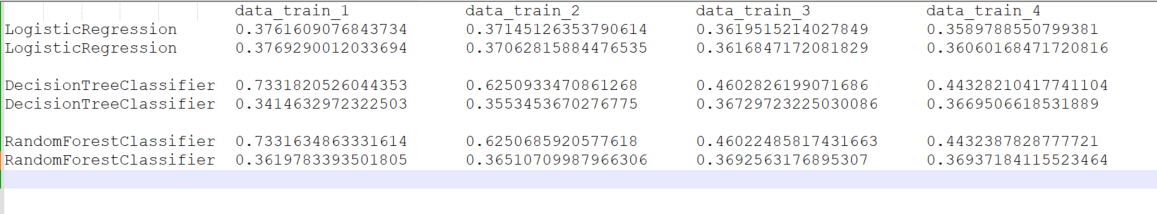


# I choose LogisticRegression with data_train_1 now I do the fit without splitting them into train and test but complete and I make the predictions with the test.csv data to upload the response to Kaggle.

In [ ]:
Xtr, ytr = data_train_1.iloc[:len(data_train_1), :-1].values, data_train_1.iloc[:len(data_train_1), -1].values #Datos completos
print (Xtr.shape, ytr.shape)

# Clean test.csv data
# this data have all its columns execept the ESTU_PRGM_ACADEMICO column
data_test_1 = data_cleanup_1(data_test_copy)
#data_test_1 = replace_rendimiento_global_with_int(data_test_1)
# Drop the original Unnamed: 0 column
data_test_1 = data_test_1.drop("Unnamed: 0", axis=1)


Xts = data_test_1.values #Datos completos
print (Xts.shape)
data_test_1.head(5)

(692500, 47) (692500,)
(296786, 47)


,PERIODO_20183,PERIODO_20184,PERIODO_20194,PERIODO_20195,PERIODO_20196,PERIODO_20202,PERIODO_20203,PERIODO_20212,PERIODO_20213,ESTU_PRGM_DEPARTAMENTO_AMAZONAS,...,ESTU_PRGM_DEPARTAMENTO_TOLIMA,ESTU_PRGM_DEPARTAMENTO_VALLE,ESTU_PRGM_DEPARTAMENTO_VAUPES,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_EDUCACIONMADRE,ESTU_PAGOMATRICULAPROPIO
ID,,,,,,,,,,,,,,,,,,,,,
550236,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0.25,5.0,3,1,6,2,1
98545,0,0,0,0,0,0,1,0,0,0,...,0,0,0,3.25,25.0,2,1,4,6,0
499179,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1.75,0.0,3,1,3,4,0
782980,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1.75,25.0,1,0,1,1,0
785185,0,0,0,0,0,0,0,1,0,0,...,0,0,0,3.25,15.0,2,1,4,4,0


In [ ]:
from sklearn.linear_model import LogisticRegression

model_logistic_regression = LogisticRegression(max_iter=100000)
model_logistic_regression.fit(Xtr, ytr)
predicts_ts = model_logistic_regression.predict(Xts)
print(predicts_ts)
print(model_logistic_regression.score(Xtr, ytr))
print(model_logistic_regression.score(Xts, predicts_ts))

[1 4 4 ... 4 4 3]
0.37621516245487363
1.0


# Submission

In [ ]:
predicts_ts_df = pd.Series(predicts_ts, name="RENDIMIENTO_GLOBAL")
predicts_ts_df

,RENDIMIENTO_GLOBAL
0,1
1,4
2,4
3,1
4,1
...,...
296781,2
296782,4
296783,4
296784,4


In [ ]:
predicts_ts_df = predicts_ts_df.map({
      1: 'bajo',
      2: 'medio-bajo',
      3: 'medio-alto',
      4: 'alto'
  })
predicts_ts_df

,RENDIMIENTO_GLOBAL
0,bajo
1,alto
2,alto
3,bajo
4,bajo
...,...
296781,medio-bajo
296782,alto
296783,alto
296784,alto


In [ ]:
submission = pd.DataFrame([data_test_copy["ID"] , predicts_ts_df]).T
submission.head()

,ID,RENDIMIENTO_GLOBAL
0,550236,bajo
1,98545,alto
2,499179,alto
3,782980,bajo
4,785185,bajo


In [ ]:
submission.to_csv("submission.csv", index=False)

In [ ]:
!head submission.csv

ID,RENDIMIENTO_GLOBAL
550236,bajo
98545,alto
499179,alto
782980,bajo
785185,bajo
58495,medio-bajo
705444,alto
557548,alto
519909,bajo


In [ ]:
submission.shape

(296786, 2)